In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from scipy.ndimage.filters import gaussian_filter

In [2]:
ztbl = Table.read('zcat.deep2.dr4.fits.gz', format='fits')
zcat = ztbl.to_pandas() # convert to pandas dataframe
zcat.head()

,OBJNO,RA,DEC,MAGB,MAGR,MAGI,MAGBERR,MAGRERR,MAGIERR,RG,...,ZBEST,ZERR,ZQUALITY,CLASS,SUBCLASS,RCHI2,DOF,VDISP,VDISPERR,COMMENT
0,11001673,213.868704,51.956445,23.487745,23.143082,22.582092,0.026491,0.022043,0.029253,1.369818,...,-1.000000,999.900024,2,b'NONE ',b'NONE ',0.630934,57,999.900024,999.900024,b'bcol; bext ...
1,11001699,213.810471,51.942316,22.067692,20.034674,19.545080,0.009000,0.001478,0.002079,1.957290,...,0.290608,0.000043,4,b'GALAXY',b'NONE ',1.178153,5901,166.334991,49.481255,b' ...
2,11001770,213.848431,51.948876,24.144438,24.103180,24.020006,0.068268,0.076603,0.152493,2.184211,...,-1.000000,-5.000000,1,b'GALAXY',b'NONE ',1.047260,5318,184.860001,195.000000,b' ...
3,11001800,213.831758,51.952548,25.336836,23.508480,23.081087,0.169422,0.033245,0.049654,1.795907,...,-1.000000,-5.000000,1,b'GALAXY',b'NONE ',1.014062,5788,0.000000,0.000000,b' ...
4,11001860,213.832550,51.954174,24.382738,23.401484,22.572845,0.079261,0.033940,0.035031,2.023320,...,0.957669,0.000099,4,b'GALAXY',b'NONE ',1.039979,5952,109.394997,17.208755,b' ...


In [3]:
zcat = zcat[zcat['ZQUALITY'] >= 3] # remove stars/sources with low accuracy or no redshift calculations
zcat = zcat[zcat['ZBEST'] != -1] # remove stars, redundant if ZQUALITY >= 3
zcat = zcat[zcat['ZERR'] >= 0] # ZERR < 0 indicates problematic fit

In [4]:
spec1 = Table.read('spec1d.1100.000.11001922.fits', hdu=1, format='fits') #first spec1d sky sample from 1100 folder in tar file
spec1[:]

FileNotFoundError: [Errno 2] No such file or directory: 'spec1d.1100.000.11001922.fits'

In [6]:
print(len(spec1['SPEC'].T))

4096


In [7]:
spec2 = Table.read('spec1d.1100.000.11001922.fits', hdu=2, format='fits') #first spec1d sky sample from 1100 folder in tar file
spec2[:]

SPEC [4096],LAMBDA [4096],IVAR [4096],CRMASK [4096],BITMASK [4096],ORMASK [4096],NBADPIX [4096],INFOMASK [4096],OBJPOS,FWHM,NSIGMA,R1,R2,SKYSPEC [4096],IVARFUDGE
float32,float32,float32,int16,int16,int16,int16,int16,float32,float32,float32,int32,int32,float32,float32
0.0 .. 0.0,7726.933 .. 9005.809,0.0 .. 0.0,13 .. 13,0 .. 0,15 .. 15,13 .. 13,13 .. 13,28.131037,9.2196245,1.1,22,34,-1528.1206 .. 1628.0889,0.6852712


In [8]:
max(spec2['IVAR'].T)

array([0.01335585], dtype=float32)

In [9]:
spec3 = Table.read('spec1d.1100.000.11001922.fits', hdu=3, format='fits') #first spec1d sky sample from 1100 folder in tar file
spec3[:]

SPEC [4096],LAMBDA [4096],IVAR [4096],CRMASK [4096],BITMASK [4096],ORMASK [4096],NBADPIX [4096],INFOMASK [4096],OBJPOS,FWHM,NSIGMA,R1,R2,SKYSPEC [4096],IVARFUDGE
float32,float32,float32,int16,int16,int16,int16,int16,float32,float32,float32,int32,int32,float32,float32
0.0 .. 0.0,6412.8623 .. 7721.4297,0.0 .. 0.0,13 .. 13,0 .. 0,15 .. 15,13 .. 13,13 .. 13,28.131037,9.2196245,1.75,22,34,206.18007 .. 77.587135,1.1636956


In [10]:
spec4 = Table.read('spec1d.1100.000.11001922.fits', hdu=4, format='fits') #first spec1d sky sample from 1100 folder in tar file
spec4[:]

SPEC [4096],LAMBDA [4096],IVAR [4096],CRMASK [4096],BITMASK [4096],ORMASK [4096],NBADPIX [4096],INFOMASK [4096],OBJPOS,FWHM,NSIGMA,R1,R2,SKYSPEC [4096],IVARFUDGE
float32,float32,float32,int16,int16,int16,int16,int16,float32,float32,float32,int32,int32,float32,float32
0.0 .. 0.0,7726.933 .. 9005.809,0.0 .. 0.0,13 .. 13,0 .. 0,15 .. 15,13 .. 13,13 .. 13,28.131037,9.2196245,1.75,22,34,-1528.1206 .. 1628.0889,1.0


In [5]:
import tarfile
tf = tarfile.open("mask.1100-1103.tar") 
tf.extractall() #unpack tarfile

FileNotFoundError: [Errno 2] No such file or directory: 'mask.1100-1103.tar'

In [6]:
import glob
path1100=glob.glob('1100/2003may03/spec1d*.fits') #unpacks all spec1d information in folders
path1101=glob.glob('1101/2003may06/spec1d*.fits') 
path1102=glob.glob('1102/2003jun30/spec1d*.fits') 
path1103=glob.glob('1103/2003may03/spec1d*.fits') 
mask_1100_1103=[path1100, path1101, path1102, path1103]

In [12]:
def match_int(mask):
    IDpath=[]
    IDzcat=[]
    combined=[]
    for path in mask:
        numbers = list(map(lambda sub:int(''.join( [ele for ele in sub if ele.isnumeric()])), path)) # Extracting numbers from list of strings in filenames in tarball 
        
        for t in numbers:
            ID=str(t)[-8:] #gives last 8 digits of the number attained from res (which gives us the OBJNO)
            ID=int(ID)
            IDpath.append(ID) #new list that has the OBJNO that are in the files


    #converting pandas table into normal list
    for n in zcat['OBJNO']:
        IDzcat.append(n)

    #making list of matching objectnumbers

    for x in IDpath:
        if x in IDzcat:
            row=zcat.loc[zcat['OBJNO']==x].index[0] #find row numbers with the matching IDs
            z=zcat['Z'].T[row] #gives us the z values for the matching ID numbers
            if z<.1 and z>-.1:
                combined.append(x)
    return(combined)

print((match_int(mask_1100_1103)))

[11001922, 11008371, 11021407, 11007167, 11014320, 11014405, 11014395, 11020434, 11020555, 11021201, 11028420, 11007167, 11020744]


In [13]:
#copied list to make program run faster for lambda_spec defintion ahead
MatchInt=[11001922, 11008371, 11021407, 11007167, 11014320, 11014405, 11014395, 11020434, 11020555, 11021201, 11028420, 11007167, 11020744]
print(MatchInt)

[11001922, 11008371, 11021407, 11007167, 11014320, 11014405, 11014395, 11020434, 11020555, 11021201, 11028420, 11007167, 11020744]


In [14]:
def match_str(int_def):
    b=[]
    for x in int_def:
        x=str(x)
        b.append(x)
    return(b)

print(match_str(match_int(mask_1100_1103)))

['11001922', '11008371', '11021407', '11007167', '11014320', '11014405', '11014395', '11020434', '11020555', '11021201', '11028420', '11007167', '11020744']


In [15]:
#copied list to make program run faster for lambda_spec defintion ahead
MatchStr=['11001922', '11008371', '11021407', '11007167', '11014320', '11014405', '11014395', '11020434', '11020555', '11021201', '11028420', '11007167', '11020744']
print(MatchStr)

['11001922', '11008371', '11021407', '11007167', '11014320', '11014405', '11014395', '11020434', '11020555', '11021201', '11028420', '11007167', '11020744']


1100/2003may03\spec1d.1100.000.11001922.fits
1100/2003may03\spec1d.1100.056.11008371.fits
1100/2003may03\spec1d.1100.139.11021407.fits
1102/2003jun30\spec1d.1102.019.11007167.fits
1102/2003jun30\spec1d.1102.051.11014320.fits
1102/2003jun30\spec1d.1102.062.11014405.fits
1102/2003jun30\spec1d.1102.072.11014395.fits
1102/2003jun30\spec1d.1102.092.11020434.fits
1102/2003jun30\spec1d.1102.095.11020555.fits
1102/2003jun30\spec1d.1102.111.11021201.fits
1102/2003jun30\spec1d.1102.152.11028420.fits
1103/2003may03\spec1d.1103.020.11007167.fits
1103/2003may03\spec1d.1103.063.11020744.fits
None


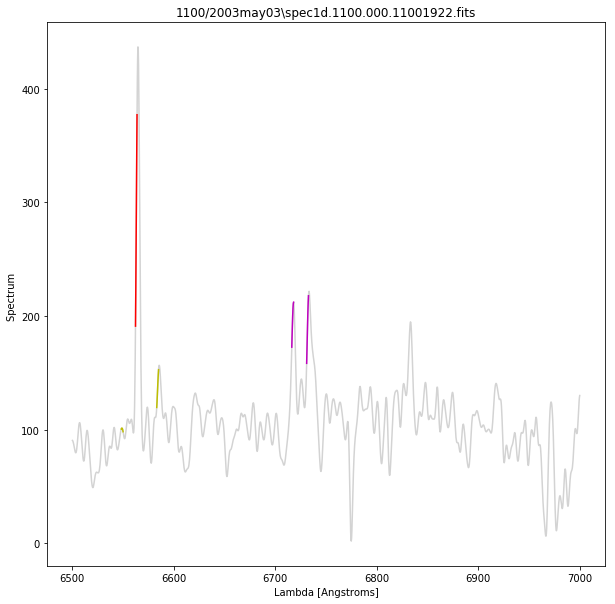

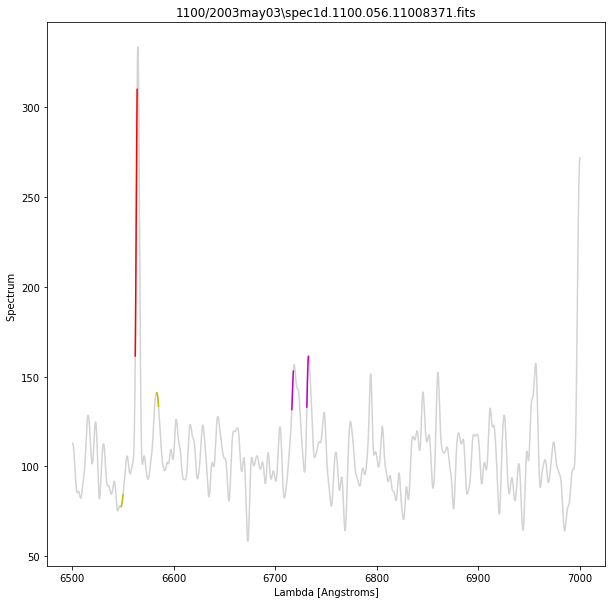

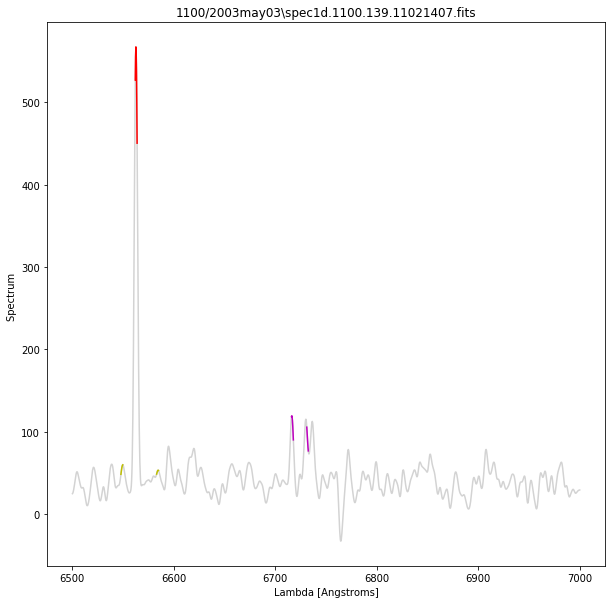

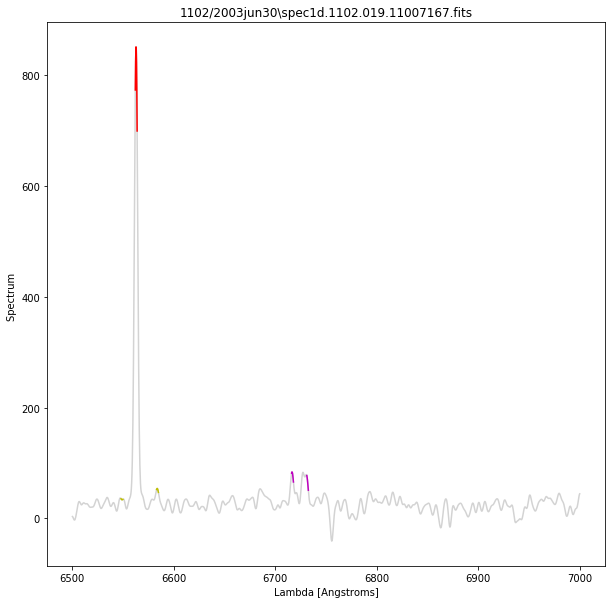

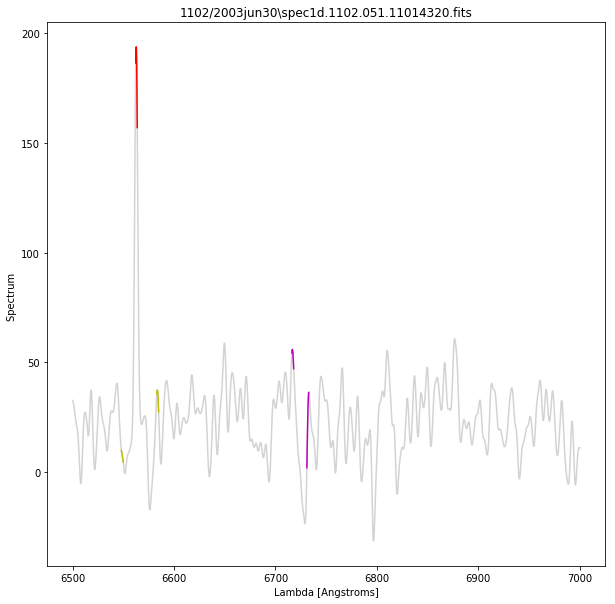

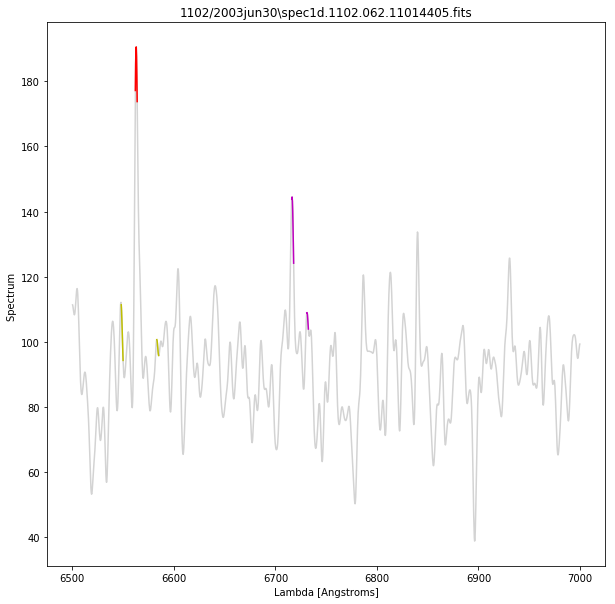

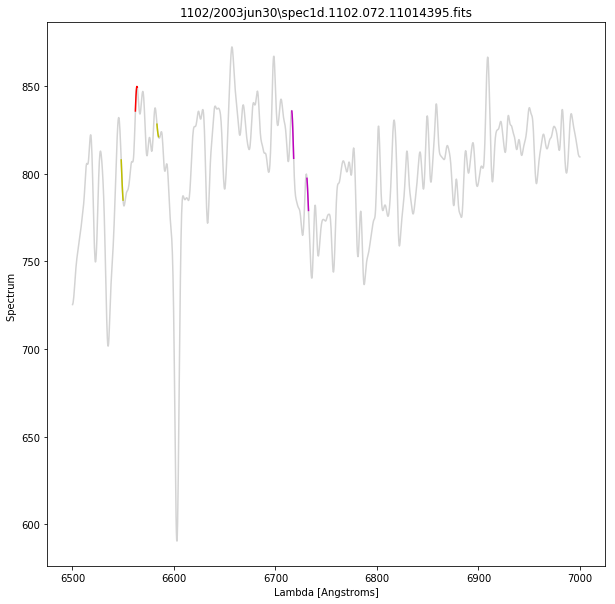

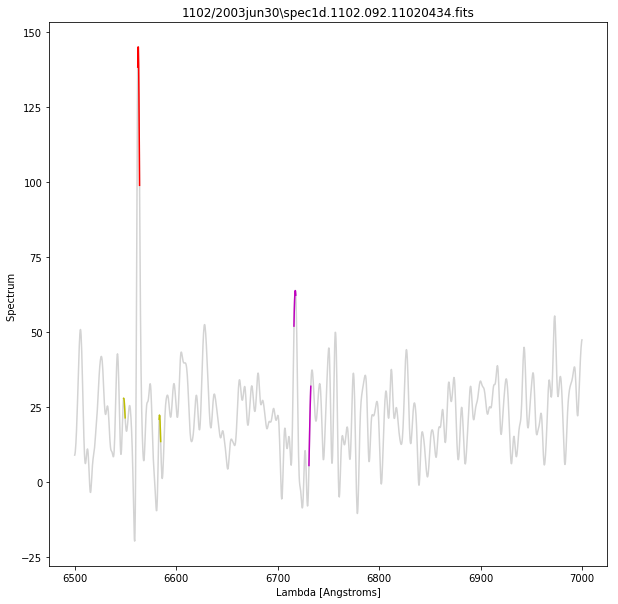

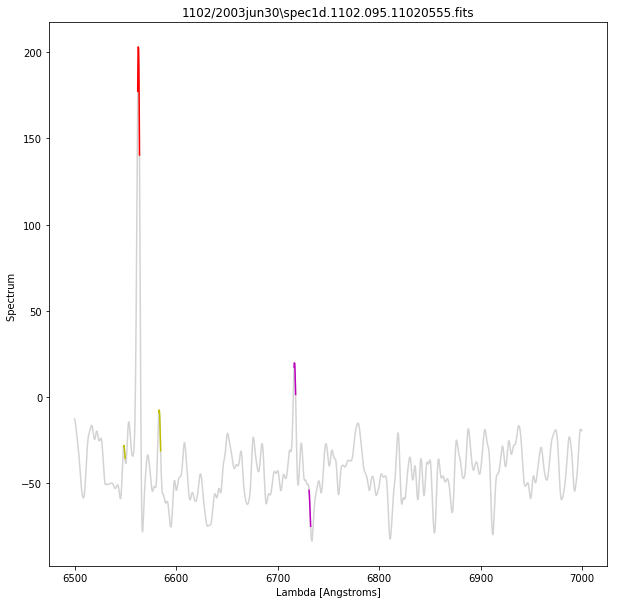

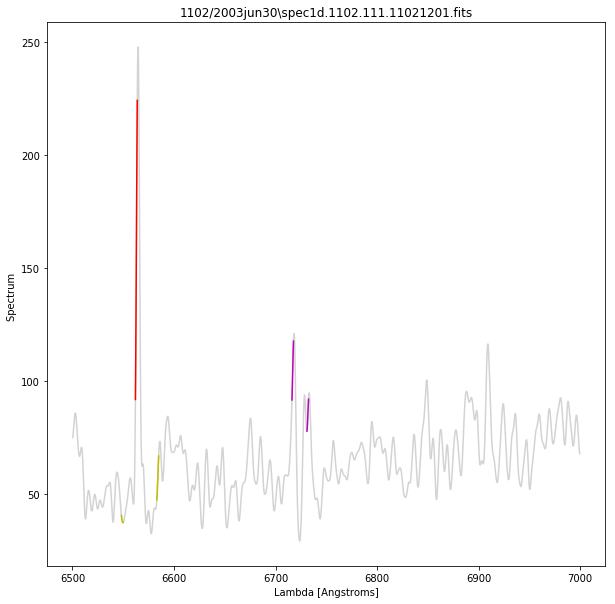

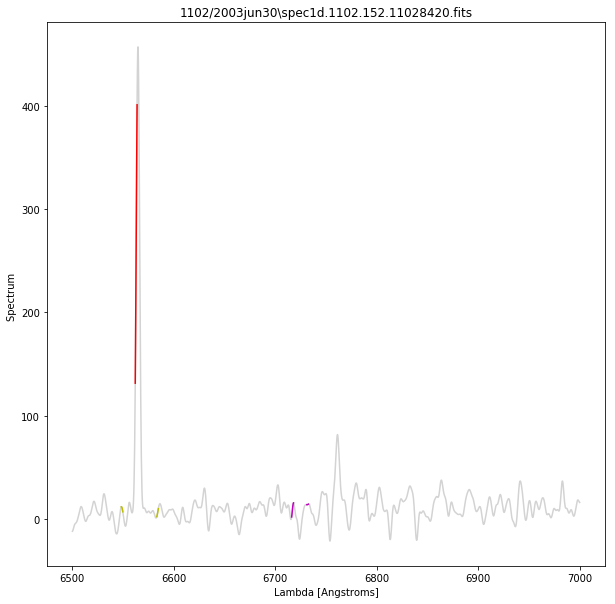

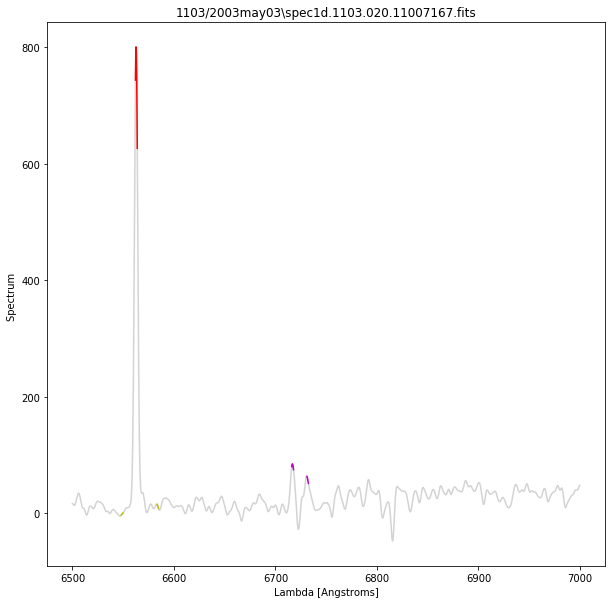

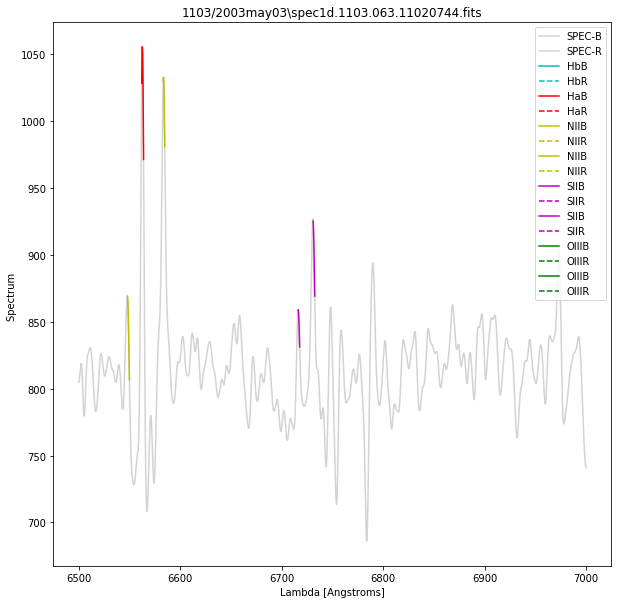

In [22]:
#### accounts for redshift to find actual lambda
%matplotlib inline
def Lambda_spec(mask):
    for path in mask:
        for check in path:
            specB=[]
            specR=[]
            lambdaB=[]
            lambdaR=[]
            lambB=[]
            lambR=[]
            HbB=[]
            HbR=[]
            Hb_specR=[]
            Hb_specB=[]
            HaB=[]
            HaR=[]
            Ha_specR=[]
            Ha_specB=[]
            NIIB=[]
            NIIB2=[]
            NIIR=[]
            NIIR2=[]
            NII_specR=[]
            NII2_specR=[]
            NII_specB=[]
            NII2_specB=[]
            SIIB=[]
            SIIB2=[]
            SIIR=[]
            SIIR2=[]
            SII_specR=[]
            SII2_specR=[]
            SII_specB=[]
            SII2_specB=[]
            OIIIB=[]
            OIIIB2=[]
            OIIIR=[]
            OIIIR2=[]
            OIII_specR=[]
            OIII2_specR=[]
            OIII_specB=[]
            OIII2_specB=[]
            same = [ele for ele in MatchStr if(ele in check)] #finds matching ID in folder of tarball
            if bool(same)==True:
                print(check)
                hdu3 = Table.read(check, hdu=3, format='fits')
                hdu4 = Table.read(check, hdu=4, format='fits')
                specb = hdu3['SPEC']
                specr = hdu4['SPEC']
                ID=[]
                for s in check:
                    if s.isnumeric():
                        s=int(s)
                        ID.append(s) #gives us the object number of the file name as a list
                ID=ID[-8:]
                s = [str(i) for i in ID] # Converting list to string list 
                res = int("".join(s)) # Join list items to make the whole object number
                for n in MatchInt:
                    if n==res:
                        row=zcat.loc[zcat['OBJNO']==n].index[0] #find row numbers with the matching IDs
                        z=zcat['Z'].T[row] #gives us the z values for the matching ID numbers
                        lambdab = (hdu3['LAMBDA'])/(z+1) 
                        lambdar = (hdu4['LAMBDA'])/(z+1)
                
        
                        
                for c in lambdab:
                    l_b=[]
                    for b in c:
                        l_b.append(b)
                        s_b=[]
                        if b>6500 and b<7000:
                            lambdaB.append(b)
                            matchb=l_b.index(b) #find row numbers with the matching IDs
                            [s_b.append(y) for x in specb for y in x ]
                            spec3=s_b[matchb]
                            specB.append(spec3)
                            
#                 lambdaB = gaussian_filter(lambdaB, sigma=5) #smooth out lambda to decrease noise    
                specB = gaussian_filter(specB, sigma=5) #smooth out lambda to decrease noise
                
                for d in lambdar:
                    l_r=[]
                    for r in d:
                        l_r.append(r)
                        s_r=[]
                        if r>6500 and r<6800:
                            lambdaR.append(r)
                            matchr=l_r.index(r) #find row numbers with the matching IDs
                            [s_r.append(y) for x in specr for y in x ]
                            spec4=s_r[matchr]
                            specR.append(spec4)
                specR = gaussian_filter(specR, sigma=5)
#                 lambdaR = gaussian_filter(lambdaR, sigma=5) #smooth out lambda to decrease noise 
#                 lambdaB.append(lambdab)
#                 lambdaR.append(lambdar)
#                 print(lambdaB)
    #     return(lambdaB, lambdaR)
                l_B=[]
                for e in lambdaB:
                    s_B=[]
                    l_B.append(e)
                    if e >= 4861 and e <= 4863: #H-beta wavelenghts
                        Hb = e
                        HbB.append(Hb)
                        row=l_B.index(Hb) 
                        [s_B.append(y) for y in specB]
                        Hb_spec=s_B[row]  
                        Hb_specB.append(Hb_spec)

                    if e >= 6562 and e <= 6564: #H-alpha wavelenghts
                        Ha = e
                        HaB.append(Ha)
                        row=l_B.index(Ha) #find row numbers that meet criteria
                        [s_B.append(y) for y in specB] #makes list of spec info
                        Ha_spec=s_B[row]  #spectra for the row that the desired wavelength is found
                        Ha_specB.append(Ha_spec) #list of spectra

                    if e >= 6583 and e <= 6585: #NII wavelenghts
                        NII = e
                        NIIB.append(NII)
                        row=l_B.index(NII) #find row numbers that meet criteria
                        [s_B.append(y) for y in specB]
                        NII_spec=s_B[row]  #spectra for that row
                        NII_specB.append(NII_spec)

                    if e >= 6548 and e <= 6550: #another NII wavelength 
                        NII2 = e
                        NIIB2.append(NII2)
                        row=l_B.index(NII2) #find row numbers that meet criteria
                        [s_B.append(y) for y in specB]
                        NII2_spec=s_B[row]  #spectra for that row
                        NII2_specB.append(NII2_spec)

                    if e >= 6716 and e <= 6718: #SII wavelength
                        SII = e
                        SIIB.append(SII)
                        row=l_B.index(SII) #find row numbers that meet criteria
                        [s_B.append(y) for y in specB]
                        SII_spec=s_B[row]  #spectra for that row
                        SII_specB.append(SII_spec)

                    if e >=6730.8 and e <= 6732.8:
                        SII2 = e
                        SIIB2.append(SII2)
                        row=l_B.index(SII2) #find row numbers that meet criteria
                        [s_B.append(y) for y in specB]
                        SII2_spec=s_B[row]  #spectra for that row
                        SII2_specB.append(SII2_spec)

                    if e >= 5006 and e <= 5008:
                        OIII = e
                        OIIIB.append(OIII)
                        row=l_B.index(OIII) #find row numbers that meet criteria
                        [s_B.append(y) for y in specB]
                        OIII_spec=s_B[row]  #spectra for that row
                        OIII_specB.append(OIII_spec)


                    if e >= 4958 and e <= 4960:
                        OIII2 = e
                        OIIIB2.append(OIII2)
                        row=l_B.index(OIII2) #find row numbers that meet criteria
                        [s_B.append(y) for y in specB]
                        OIII2_spec=s_B[row]  #spectra for that row
                        OIII2_specB.append(OIII2_spec)

                #print(lambdaR.T)
                l_R=[]
                for e in lambdaR:
                    s_R=[]
                    l_R.append(e)
                    if e >= 4861 and e <= 4863:
                        Hb = e
                        HbR.append(Hb)
                        row=l_R.index(Hb) #find row numbers that meet criteria
                        [s_R.append(y) for y in specR]
                        Hb_spec=s_R[row]  #spectra for that row
                        Hb_specR.append(Hb_spec)

                    if e >= 6562 and e <= 6564:
                        Ha = e
                        HaR.append(Ha)
                        row=l_R.index(Ha) #find row numbers that meet criteria
                        [s_R.append(y) for y in specR]
                        Ha_spec=s_R[row]  #spectra for that row
                        Ha_specR.append(Ha_spec)

                    if e >= 6583 and e <= 6585:
                        NII = e
                        NIIR.append(NII)
                        row=l_R.index(NII) #find row numbers that meet criteria
                        [s_R.append(y) for y in specR]
                        NII_spec=s_R[row]  #spectra for that row
                        NII_specR.append(NII_spec)

                    if e >= 6548 and e <= 6550:
                        NII2 = e
                        NIIR2.append(NII2)
                        row=l_R.index(NII2) #find row numbers that meet criteria
                        [s_R.append(y) for y in specR]
                        NII2_spec=s_R[row]  #spectra for that row
                        NII2_specR.append(NII2_spec)

                    if e >= 6716 and e <= 6718:
                        SII = e
                        SIIR.append(SII)
                        row=l_R.index(SII) #find row numbers that meet criteria
                        [s_R.append(y) for y in specR]
                        SII_spec=s_R[row]  #spectra for that row
                        SII_specR.append(SII_spec)

                    if e >= 6730.8 and e <= 6732.8:
                        SII2 = e
                        SIIR2.append(SII2)
                        row=l_R.index(SII2) #find row numbers that meet criteria
                        [s_R.append(y) for y in specR]
                        SII2_spec=s_R[row]  #spectra for that row
                        SII2_specR.append(SII2_spec)

                    if e >= 5006 and e <= 5008:
                        OIII = e
                        OIIIR.append(OIII)
                        row=l_R.index(OIII) #find row numbers that meet criteria
                        [s_R.append(y) for y in specR]
                        OIII_spec=s_R[row]  #spectra for that row
                        OIII_specR.append(OIII_spec)

                    if e >= 4958 and e <= 4960:
                        OIII2 = e
                        OIIIR2.append(OIII2)
                        row=l_R.index(OIII2) #find row numbers that meet criteria
                        [s_R.append(y) for y in specR]
                        OIII2_spec=s_R[row]  #spectra for that row
                        OIII2_specR.append(OIII2_spec)

    #             print('H-beta Blue: ', HbB)
    #             print('H-beta Blue Spectrum: ', Hb_specB)
    #             print('H-alpha Blue: ', HaB)
    #             print('H-alpha Blue Spectrum: ', Ha_specB)
    #             print('NII Blue: ', NIIB)
    #             print('NII Blue Spectrum: ', NII_specB)
    #             print('NII Blue second type: ', NIIB2)
    #             print('NII Blue Spectrum second type: ', NII2_specB)
    #             print('SII Blue: ', SIIB)
    #             print('SII Blue Spectrum: ', SII_specB)
    #             print('SII Blue second type: ', SIIB2)
    #             print('SII Blue Spectrum second type: ', SII2_specB)
    #             print('OIII Blue: ', OIIIB)
    #             print('OIII Blue Spectrum: ', OIII_specB)
    #             print('OIII Blue second type: ', OIIIB2)
    #             print('OIII Blue Spectrum second type: ', OIII2_specB)
    #             print('H-beta Red: ', HbR)
    #             print('H-beta Red Spectrum: ', Hb_specR)
    #             print('H-alpha Red: ', HaR)
    #             print('H-alpha Red Spectrum: ', Ha_specR)
    #             print('NII Red: ', NIIR)
    #             print('NII Red Spectrum: ', NII_specR)
    #             print('NII Red second type: ', NIIR2)
    #             print('NII Red Spectrum second type: ', NII2_specR)
    #             print('SII Red: ', SIIR)
    #             print('SII Red Spectrum: ', SII_specR)
    #             print('SII Red second type: ', SIIR2)
    #             print('SII Red Spectrum second type: ', SII2_specR)
    #             print('OIII Red: ', OIIIR)
    #             print('OIII Red Spectrum: ', OIII_specR)
    #             print('OIII Red second type: ', OIIIR2)
    #             print('OIII Red Spectrum second type: ', OIII2_specR)


                fig, ax = plt.subplots(figsize=(10,10))
                ax.plot(lambdaB, specB, color='lightgrey', label='SPEC-B')
                ax.plot(lambdaR, specR, color='lightgrey', label='SPEC-R')
                ax.plot(HbB, Hb_specB , color='c', label='HbB' )
                ax.plot(HbR, Hb_specR , color='c', linestyle='--', label='HbR' )
                ax.plot(HaB, Ha_specB , color='r', label='HaB' )
                ax.plot(HaR, Ha_specR , color='r', linestyle='--', label='HaR' )
                ax.plot(NIIB, NII_specB , color='y', label='NIIB' )
                ax.plot(NIIR, NII_specR , color='y', linestyle='--', label='NIIR' )
                ax.plot(NIIB2, NII2_specB , color='y', label='NIIB' )
                ax.plot(NIIR2, NII2_specR , color='y', linestyle='--', label='NIIR' )
                ax.plot(SIIB, SII_specB , color='m', label='SIIB' )
                ax.plot(SIIR, SII_specR , color='m', linestyle='--', label='SIIR' )
                ax.plot(SIIB2, SII2_specB , color='m', label='SIIB' )
                ax.plot(SIIR2, SII2_specR , color='m', linestyle='--', label='SIIR' )
                ax.plot(OIIIB, OIII_specB , color='g', label='OIIIB' ) 
                ax.plot(OIIIR, OIII_specR , color='g', linestyle='--', label='OIIIR' ) 
                ax.plot(OIIIB2, OIII2_specB , color='g', label='OIIIB' ) 
                ax.plot(OIIIR2, OIII2_specR , color='g', linestyle='--', label='OIIIR' )
                ax.set_xlabel( 'Lambda [Angstroms]')
                ax.set_ylabel('Spectrum ')
                plt.title(check)
    plt.legend(loc='upper right')


print(Lambda_spec(mask_1100_1103))


In [42]:
zcat['OBJNO'].index(11001699)

TypeError: 'Int64Index' object is not callable